## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [3]:
from PIL import Image, ImageDraw, ImageFont

In [4]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

Uncomment the first time you run this notebook.

In [5]:
il = ImageItemList.from_folder(path_hr)
parallel(crappify, il.items)

In [6]:
parallel??

```python
Signature: parallel(func, arr: Collection, max_workers: int = None)
Source:   
def parallel(func, arr:Collection, max_workers:int=None):
    "Call `func` on every element of `arr` in parallel using `max_workers`."
    max_workers = ifnone(max_workers, defaults.cpus)
    if max_workers<2: _ = [func(o,i) for i,o in enumerate(arr)]
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            futures = [ex.submit(func,o,i) for i,o in enumerate(arr)]
            for f in progress_bar(concurrent.futures.as_completed(futures), total=len(arr)): pass
File:      ~/.pyenv/versions/miniconda3-latest/envs/v1fastai/lib/python3.7/site-packages/fastai/core.py
Type:      function
```

For gradual resizing we can change the commented line here.

In [47]:
# bs,size=32, 128
# bs,size = 24,160
bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [48]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [49]:
data_gen = get_data(bs,size)

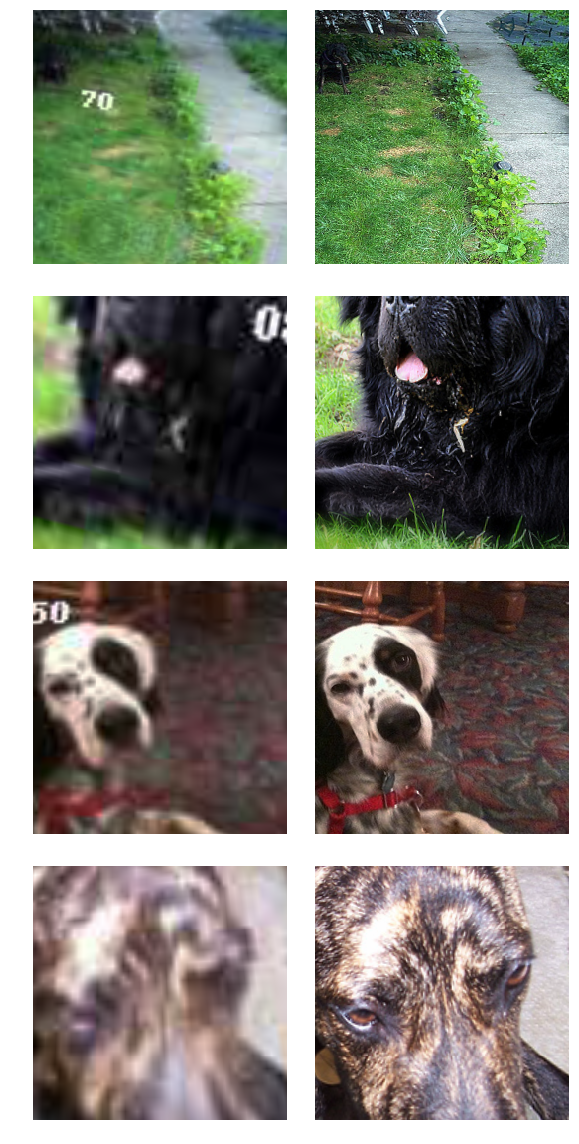

In [50]:
data_gen.show_batch(4)

In [51]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [13]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [52]:
learn_gen = create_gen_learner()

In [53]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [54]:
learn_gen.unfreeze()

In [55]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

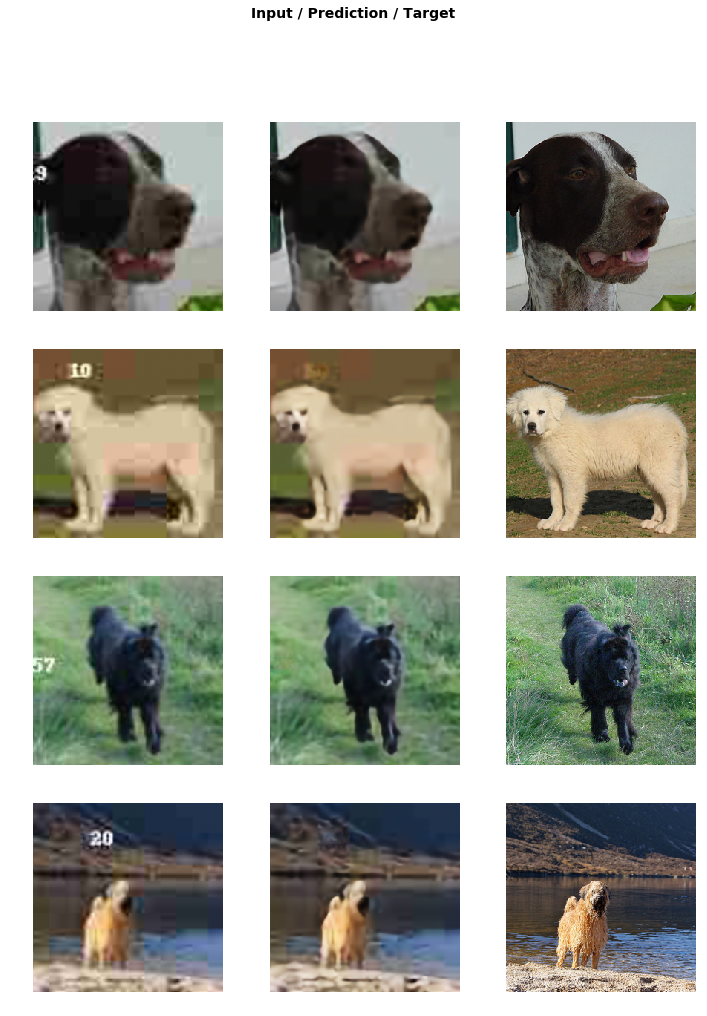

In [56]:
learn_gen.show_results(rows=4)

The above results are OK but not plausible. What matters is always architecture, loss (objective) function, and optimization algorithm. Here, we tweak **loss function**.

In [57]:
# learn_gen.save('gen-pre2')
learn_gen.save('gen-pre2-2')

## Save generated images

In [58]:
# learn_gen.load('gen-pre2');
learn_gen.load('gen-pre2-2');

In [59]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [60]:
# Use when image size is changed
shutil.rmtree(path_gen)

In [61]:
path_gen.mkdir(exist_ok=True)

In [62]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [63]:
save_preds(data_gen.fix_dl)

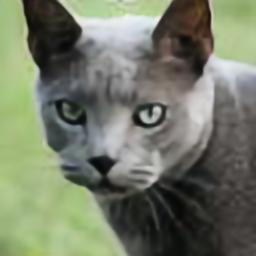

In [64]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

As mentioned above, as a tweak of loss function, we introduce adversarial loss. Here another model called Discriminator a.k.a. Critic comes.  
But note that we pre-train generator and discriminator separately.

In [65]:
learn_gen=None
gc.collect()

22261

Pretrain the critic on crappy vs not crappy.

In [66]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [67]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

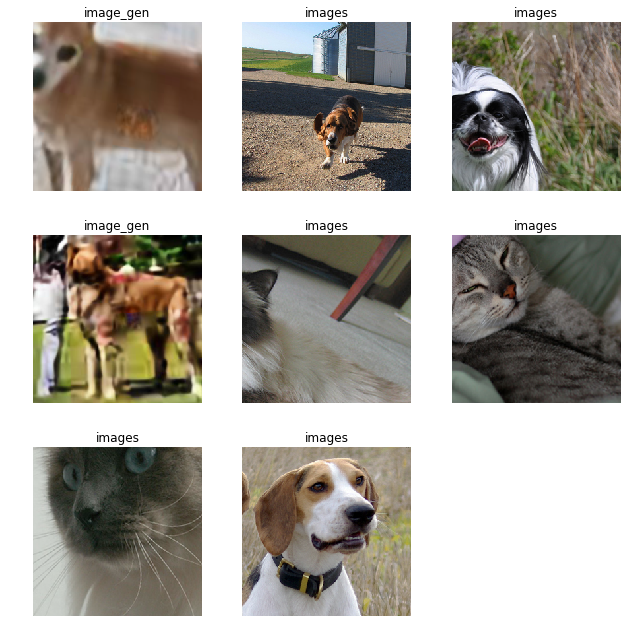

In [68]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [69]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [70]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [71]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [72]:
learn_critic.fit_one_cycle(6, 1e-3)

In [73]:
# learn_critic.save('critic-pre2')
learn_critic.save('critic-pre2-2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [81]:
learn_crit=None
learn_gen=None
gc.collect()

402

In [82]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [83]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2-2')

In [84]:
learn_gen = create_gen_learner().load('gen-pre2-2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predictions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed through the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [85]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [86]:
lr = 1e-4

In [88]:
learn.data.train_dl.batch_size=4

In [89]:
learn.fit(40,lr)

In [90]:
# learn.save('gan-1c')
learn.save('gan-1c-2')

In [91]:
learn.data=get_data(bs,size)

In [93]:
gc.collect()

3829

In [97]:
learn.load('gan-1c-2')

GANLearner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 500, 417), Image (3, 333, 500), Image (3, 332, 500), Image (3, 342, 500), Image (3, 489, 500)]...
Path: /home/crcrpar/.fastai/data/oxford-iiit-pet/crappy
x: ImageImageList (6651 items)
[Image (3, 115, 96), Image (3, 96, 144), Image (3, 96, 144), Image (3, 96, 140), Image (3, 96, 98)]...
Path: /home/crcrpar/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 375, 500), Image (3, 379, 480), Image (3, 500, 496), Image (3, 334, 500), Image (3, 375, 500)]...
Path: /home/crcrpar/.fastai/data/oxford-iiit-pet/crappy
x: ImageImageList (739 items)
[Image (3, 96, 128), Image (3, 96, 121), Image (3, 96, 96), Image (3, 96, 143), Image (3, 96, 128)]...
Path: /home/crcrpar/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(

In [96]:
learn.fit(10,lr/2)

KeyboardInterrupt: 

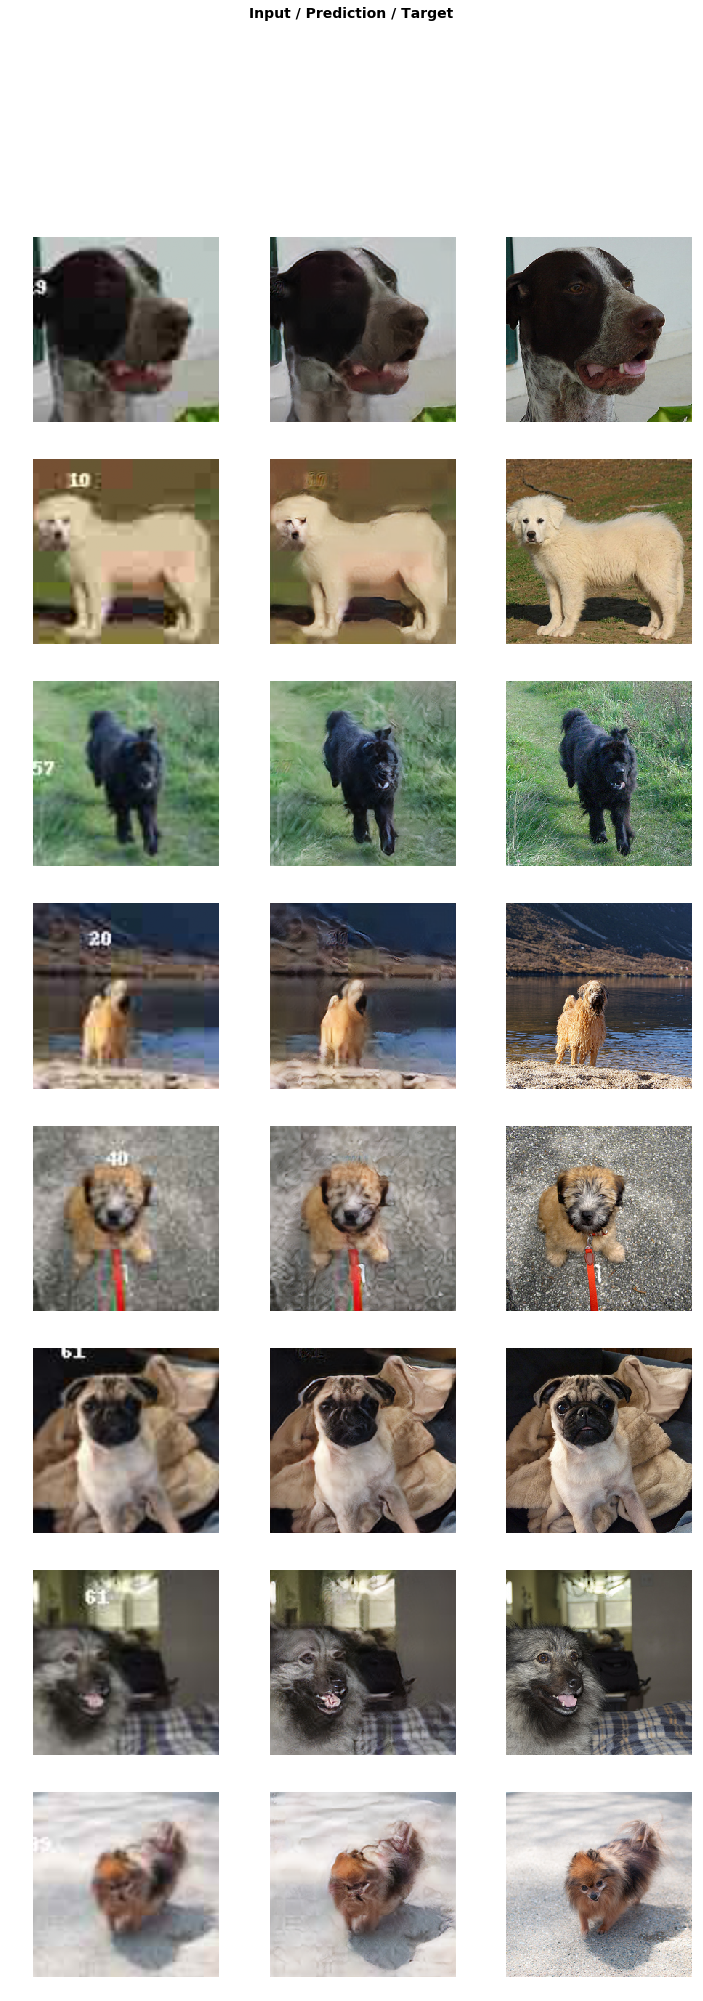

In [98]:
learn.show_results(rows=16)

In [ ]:
# learn.save('gan-1c')
learn.save('gan-1c-2')

## fin